In [1]:
# Setup

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy import integrate
from matplotlib.patches import Circle
import matplotlib.animation as animation
from scipy import spatial

from utils.plot.utils import plot_second_order_phase_portrait, plot_second_order_phase_portrait_polar

plt.rcParams["figure.figsize"] = (20, 20)

def saveFig(filename, chapter):
  plt.savefig(f"plots/chapter{chapter}/{filename}.png", facecolor="w")

# Chapter 9 - Lorenz Equations

$$
\begin{align*}
\dot{x} &= \sigma(y - x) \\
\dot{y} &= rx - y - xz \\
\dot{z} &= xy - bz
\end{align*}
$$
With $\sigma, r, b > 0$

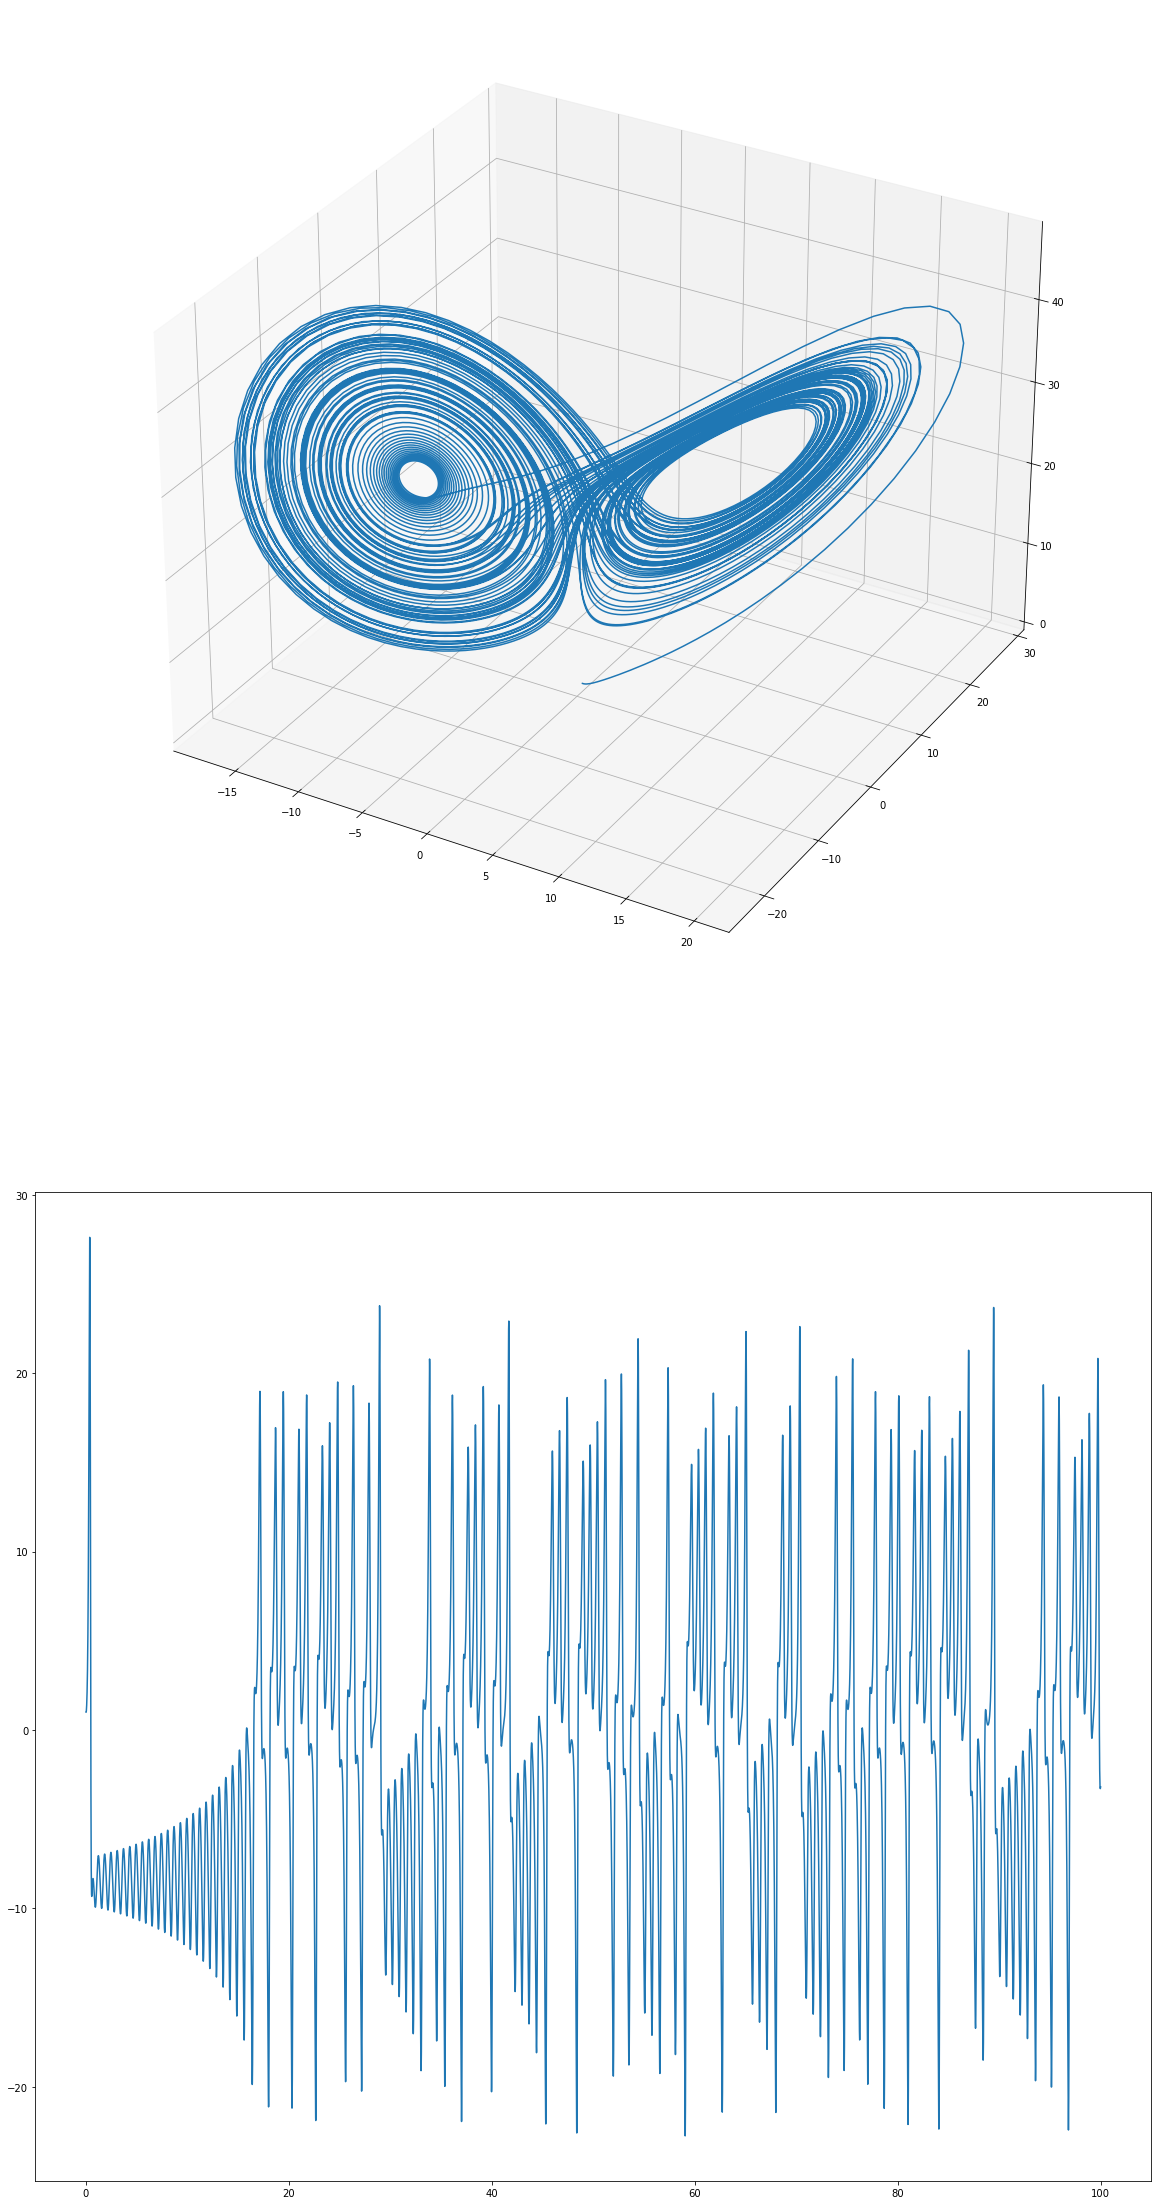

In [2]:
def lorenz(sigma, b, r):
  return lambda t, y: [sigma * (y[1] - y[0]), r * y[0] - y[1] - y[0] * y[2], y[0] * y[1] - b * y[2]]

sol = integrate.solve_ivp(lorenz(10, 8/3, 28), [0, 100], [0, 1, 0], max_step=.01)

# %matplotlib widget
%matplotlib inline

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(2, 1, 1, projection="3d")

ax.plot(sol.y[0], sol.y[1], sol.y[2])

ax = fig.add_subplot(2, 1, 2)
ax.plot(sol.t, sol.y[1])

plt.show()

In [38]:
from IPython import display

# %matplotlib widget
%matplotlib inline

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(2, 1, 1, projection="3d")
ax.set_xlim([-20, 20])
ax.set_ylim([-30, 30])
ax.set_zlim([-40, 40])

line, = ax.plot([], [], [])

xdata, ydata, zdata = [], [], []

values = sol.y.T

prev_frame = [0, 1, 0]

def run(frame):
  x, y, z = frame

  xdata.append(x)
  ydata.append(y)
  zdata.append(z)

  line.set_data_3d([xdata, ydata, zdata])

anim = animation.FuncAnimation(fig, run, values[:5000:2], interval=50)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

The trajectories are all attracted to a zero volume set called a **strange attractor**, the set appears to be two joined surfaces (which would violate the uniqueness theorem), but it is actually made up of infinite layers of surfaces (and is thus a fractal).

The separation of nearby trajectories grows exponentially over time (as can be seen from a plot of the logarithm of the separation) until the separation becomes comparable to the size of the attractor. The exponent is called the **Liapunov exponent** $\lambda \approx 0.9$.

A concept similar to the Poincaré map can be applied by using a 1D surface (e.g. constant $z$), this is called a **Lorenz map** and applies because the attractor is approximately flat. It can be seen from the Lorenz map $f(z)$ that $|f'(z)| > 1$ which can be used to show that closed orbits are impossible. Note that the Lorenz map isn't actually a function as it has width due to the attractor not being completely 2D.

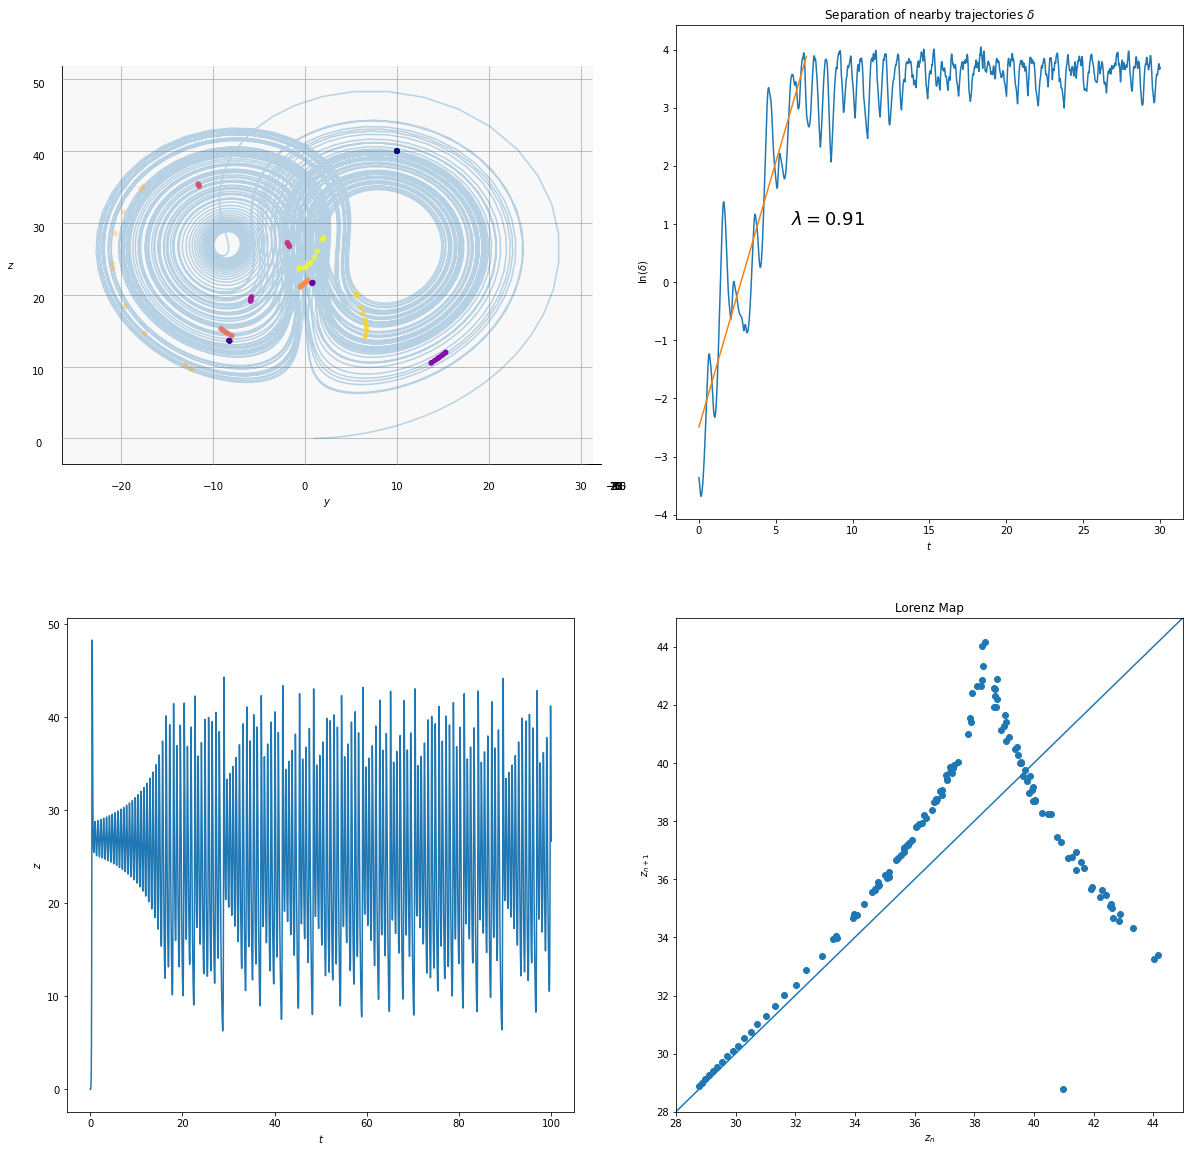

In [5]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(2, 2, 1, projection="3d")

sols = []
x0, y0, z0 = 15, 10, 40
for (delta_x0, delta_y0, delta_z0) in [
  (0, 0, 0),
  (.01, 0, 0),
  (0, .01, 0),
  (0, 0, .01),
  (.01, 0, .01),
  (-.01, 0, -.01),
  (-.01, 0, 0),
  (0, 0, -.01),
  (.01, .01, .01),
  (-.01, -.01, -.01),
]:
  sols.append(integrate.solve_ivp(lorenz(10, 8/3, 28), [0, 30], [x0 + delta_x0, y0 + delta_y0, z0 + delta_z0], max_step=.01))

ax.plot(sol.y[0], sol.y[1], sol.y[2], alpha=.3)
ax.set_proj_type("ortho")
ax.view_init(elev=0, azim=0)
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.dist = 6
for s in sols:
  ax.scatter(s.y[0][:600:50], s.y[1][:600:50], s.y[2][:600:50], cmap=plt.colormaps["plasma"], c=range(12))

ax = fig.add_subplot(2, 2, 2)
separations = [
  np.log(np.max(spatial.distance.pdist(tsols)))
  for tsols in np.array(
    [s.y.T.reshape(-1, 3) for s in sols]
  ).swapaxes(0, 1).reshape(-1, 10, 3)
]
ax.plot(sols[0].t, separations)
# Approximate endpoint for the increase in separation
index_sep_end = 700
m, c = np.polyfit(sols[0].t[:index_sep_end], separations[:index_sep_end], 1)
ax.plot([sols[0].t[0], sols[0].t[index_sep_end]], [m * t + c for t in [sols[0].t[0], sols[0].t[index_sep_end]]])
ax.text(6, 1, f"$\lambda = {round(m, 2)}$", fontsize=18)
ax.set_xlabel("$t$")
ax.set_ylabel("$\ln(\delta)$")
ax.set_title("Separation of nearby trajectories $\delta$")

z = sol.y[2]
t = sol.t

ax = fig.add_subplot(2, 2, 3)
ax.plot(t, z)
ax.set_xlabel("$t$")
ax.set_ylabel("$z$")

ax = fig.add_subplot(2, 2, 4)

with warnings.catch_warnings():
  warnings.simplefilter("ignore") # t has a zero value
  dz_dt = (z - np.roll(z, -1)) / t
# Max values for z occur at every other turning point, ignore the first one because it's anomalous
z_max = np.extract(np.sign(dz_dt) != np.sign(np.roll(dz_dt, -1)), z)[2::2]
ax.scatter(z_max, np.roll(z_max, -1))
ax.plot([0, 100], [0, 100])
ax.set_xlim([28, 45])
ax.set_ylim([28, 45])
ax.set_xlabel("$z_n$")
ax.set_ylabel("$z_{n+1}$")
ax.set_title("Lorenz Map")

plt.show()